# Introduction aux API

Dans ce notebook, on va apprendre à :
- Consommer une API avec `requests`
- Transformer les données en DataFrame avec `pandas`
- Visualiser des statistiques avec `matplotlib`
- Créer sa propre API avec `FastAPI`

- Créer une application interactive avec `Streamlit`

In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json

### Exercice 1 : Récupération de données depuis l’API INSEE

Explorateur de données INSEE : https://catalogue-donnees.insee.fr/fr/explorateur/DS_EC_NAIS

URL de l'API : https://api.insee.fr/melodi/data/DS_EC_NAIS?FREQ=M&EC_MEASURE=LVB&GEO=DEP


**Objectif** :
1. Explorer les données INSEE pour vous familiariser avec
2. Faire une requête GET avec l'url directement
3. Faire une requête GET avec l'url et l'utilisation de paramètres
4. Comprendre le format JSON
5. Explorer les données reçues
    - afficher les clés du dictionnaire
    - afficher le nombre d'éléments contenu dans la key `observations`
    - afficher le label en francais et anglais que vous trouverez dans la key `publisher`

In [25]:
url = "https://api.insee.fr/melodi/data/DS_EC_NAIS?FREQ=M&EC_MEASURE=LVB&GEO=DEP"

headers = {
    "Authorization": "Bearer VOTRE_CLE_API_ICI"
}

response = requests.get(url, headers=headers)

In [21]:
params = {
    "FREQ": "M",
    "EC_MEASURE": "LVB",
    "GEO": "DEP"
}

response = requests.get("https://api.insee.fr/melodi/data/DS_EC_NAIS", 
                        headers=headers, params=params)

data = response.json()

In [22]:
print(data.keys())

dict_keys(['identifier', 'title', 'publisher', 'observations', 'paging'])


In [23]:
print("Clés disponibles :", data.keys())
print("Nombre d'observations :", len(data["observations"]))
for item in data["publisher"]["label"]:
    if item["lang"] == "fr":
        print("Publisher FR :", item["content"])
    elif item["lang"] == "en":
        print("Publisher EN :", item["content"])

Clés disponibles : dict_keys(['identifier', 'title', 'publisher', 'observations', 'paging'])
Nombre d'observations : 1000
Publisher FR : Institut national de la statistique et des etudes economiques (INSEE)
Publisher EN : National Institute of Statistics and Economic Studies


### Exercice 2 : Mise en forme des données avec Pandas

**Objectif** :
- Transformer le JSON en DataFrame
- Colonnes : **département, mois, naissances**
- Trier les données par département et mois
- Afficher les premières lignes du DataFrame

In [26]:
observations = data["observations"]

df = pd.DataFrame(observations)

print(df.columns)
print(df.head())

Index(['dimensions', 'attributes', 'measures'], dtype='object')
                                          dimensions              attributes  \
0  {'GEO': '2024-DEP-56', 'EC_MEASURE': 'LVB', 'F...  {'OBS_STATUS_FR': 'D'}   
1  {'GEO': '2024-DEP-26', 'EC_MEASURE': 'LVB', 'F...  {'OBS_STATUS_FR': 'D'}   
2  {'GEO': '2024-DEP-48', 'EC_MEASURE': 'LVB', 'F...  {'OBS_STATUS_FR': 'D'}   
3  {'GEO': '2024-DEP-63', 'EC_MEASURE': 'LVB', 'F...  {'OBS_STATUS_FR': 'D'}   
4  {'GEO': '2024-DEP-05', 'EC_MEASURE': 'LVB', 'F...  {'OBS_STATUS_FR': 'D'}   

                                 measures  
0  {'OBS_VALUE_NIVEAU': {'value': 615.0}}  
1  {'OBS_VALUE_NIVEAU': {'value': 409.0}}  
2   {'OBS_VALUE_NIVEAU': {'value': 46.0}}  
3  {'OBS_VALUE_NIVEAU': {'value': 450.0}}  
4   {'OBS_VALUE_NIVEAU': {'value': 90.0}}  


In [ ]:
df_clean = pd.DataFrame({
    "departement": [obs["dimensions"]["GEO"] for obs in observations],
    "mois": [obs["dimensions"]["TIME_PERIOD"] for obs in observations],
    "naissances": [obs["measures"]["OBS_VALUE_NIVEAU"]["value"] for obs in observations]
})

df_clean = df_clean.sort_values(by=["departement", "mois"]).reset_index(drop=True)

df_clean["mois"] = pd.to_datetime(df_clean["mois"], format="%Y-%m")

print(df_clean.head())

   departement       mois  naissances
0  2024-DEP-01 2020-03-01       565.0
1  2024-DEP-01 2020-11-01       547.0
2  2024-DEP-01 2022-05-01       559.0
3  2024-DEP-01 2023-05-01       522.0
4  2024-DEP-01 2024-05-01       557.0


In [29]:
df_clean["departement"] = df_clean["departement"].str.extract(r"DEP-(\d+)")

df_clean["mois"] = pd.to_datetime(df_clean["mois"], format="%Y-%m").dt.to_period("M").astype(str)

df_clean = df_clean.sort_values(by=["departement", "mois"]).reset_index(drop=True)

print(df_clean.head())

  departement     mois  naissances
0          01  2020-03       565.0
1          01  2020-11       547.0
2          01  2022-05       559.0
3          01  2023-05       522.0
4          01  2024-05       557.0


### Exercice 3 : Visualisation des données

**Objectif** :
- Visualiser l’évolution des naissances pour le département 75
- Comparer plusieurs départements

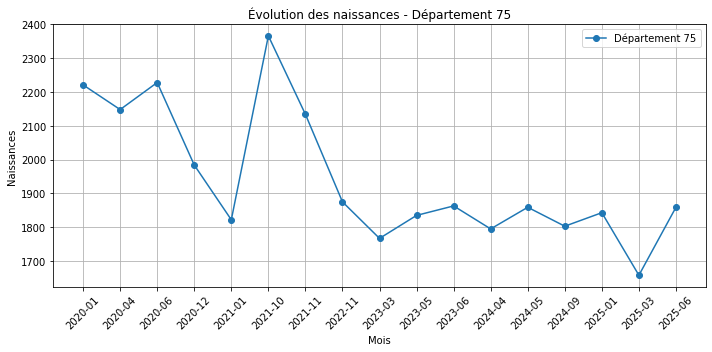

In [31]:
df_75 = df_clean[df_clean["departement"] == "75"]

plt.figure(figsize=(10,5))
plt.plot(df_75["mois"], df_75["naissances"], marker="o", label="Département 75")

plt.title("Évolution des naissances - Département 75")
plt.xlabel("Mois")
plt.ylabel("Naissances")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


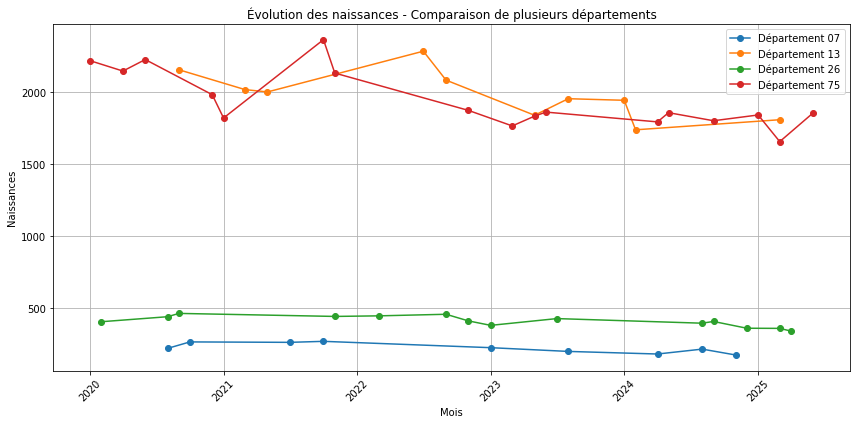

In [36]:
df_clean["mois"] = pd.to_datetime(df_clean["mois"], format="%Y-%m")

departements_a_comparer = ["07", "13", "26", "75"]

plt.figure(figsize=(12,6))

for dep in departements_a_comparer:
    df_dep = df_clean[df_clean["departement"] == dep].sort_values(by="mois")
    plt.plot(df_dep["mois"], df_dep["naissances"], marker="o", label=f"Département {dep}")

plt.title("Évolution des naissances - Comparaison de plusieurs départements")
plt.xlabel("Mois")
plt.ylabel("Naissances")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Créer un subplot 2x2 (2 lignes, 2 colonnes) qui affiche l'évolution des naissances pour les départements 75, 69, 33, 13.













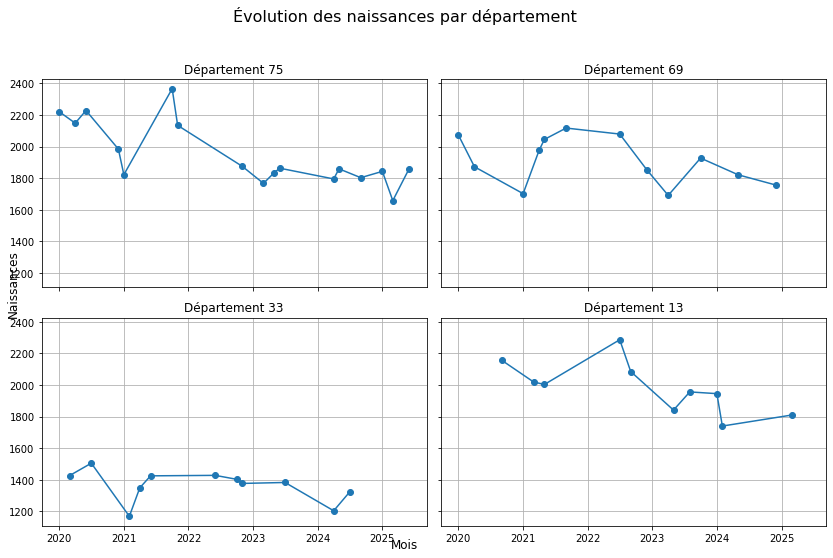

In [38]:
departements_a_afficher = ["75", "69", "33", "13"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten() 

for i, dep in enumerate(departements_a_afficher):
    df_dep = df_clean[df_clean["departement"] == dep].sort_values(by="mois")
    axes[i].plot(df_dep["mois"], df_dep["naissances"], marker="o", color="tab:blue")
    axes[i].set_title(f"Département {dep}")
    axes[i].grid(True)

fig.suptitle("Évolution des naissances par département", fontsize=16)
fig.text(0.5, 0.04, "Mois", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Naissances", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()

### Exercice 4 : Création d’une API avec FastAPI

**Objectif** :
- Endpoint `/hello/{name}` -> `str`
- Endpoint `/departments` -> `list[str]` : qui affiche la liste de tous les départements présents dans le retour api
- Endpoint `/births/{dep}` -> `list[dict]` *où chaque dict contient les clés `department`, `period` et `births`*: qui affiche les naissances pour un département et une periode donné
- Endpoint `/births/{dep}/{mois}` -> `dict` *où le dict contient les clés `department`, `period` et `births`*: qui affiche les naissances pour un département et une periode donné
- Endpoint `/insert/{dep}` -> insertion dans un fichier csv 'data/departments.csv' une ligne avec la colonne `department` et la colonne `checked`. La colonne department est la valeur de `dep` et la colonne checked est `0` par défaut.
    - Faites attention à ne pas écraser le fichier csv existant.
    - Faites attention à ne pas insérer une ligne déjà présente dans le fichier csv.
- Endpoint `/update/{dep}` -> mise à jour de la colonne `checked` de la ligne correspondant à `dep` à `1`
    - Faites attention à ne pas écraser le fichier csv existant.
    - Faites attention à ne pas mettre à jour un département qui n'existe pas dans le fichier csv. Renvoyer une erreur 500 si c'est le cas.

**Créer un dossier `api/`, l'api sera un fichier api.py et pas dans le notebook**  
**Le fichier api.py doit contenir uniquement le code pour l'api et ses endpoints**  
**Créer une classe ApiHandler qui gère les interactions avec l'api de l'INSEE et contiendra les méthodes nécessaires**  
- get_data_from_api_insee : récupère les données de l'api de l'INSEE
- create_df_from_api_insee : crée un dataframe à partir des données de l'api de l'INSEE
- get_departments : retourne la liste des départements présents dans le retour api
- get_births_by_department : retourne les naissances pour un département et une periode donné
- get_births_by_department_and_month : retourne les naissances pour un département et un mois donné  

**Veuillez à bien choisir l'endpoint à utiliser en fonction de la requête**  
**Veuillez à séparer le code en plusieurs fonctions et fichiers**

Pour lancer une api en local, il faut installer fastapi et uvicorn.

```bash
pip install fastapi uvicorn
```

Ensuite, il faut lancer l'api avec la commande suivante :

```bash
uvicorn api:app --reload
```

### Exercice 5 : Application Streamlit

**Objectif** : Créer une application streamlit qui permet de sélectionner un département et de ploter l'évolution des naissances pour ce département.
- Créer un dossier `app/`, créer un fichier app.py qui contient l'application streamlit
- Créer une class AppHandler qui contiendra les intéractions avec l'api
    - get_departments : retourne la liste des départements présents dans le retour api
    - get_births_by_department : retourne les naissances pour un département et une periode donné
    - get_births_by_department_and_period : retourne les naissances pour un département et un mois donné

Pour lancer l'application, il faut installer streamlit.

```bash
pip install streamlit
```

Ensuite, il faut lancer l'application avec la commande suivante :

```bash
streamlit run app.py
```





In [ ]:
import streamlit as st